# Evaluation Notebook Baseline

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

10


In [ ]:
# Loading the pickled queries and index
import _pickle as pickle
import bz2
import pandas as pd

eval_queries = pickle.load(bz2.BZ2File('eval_queries.pkl.bz2', 'rb'))

In [ ]:
lengths = [len(i)+len(j) for i, j in zip(eval_queries['very_relevant_entities'], eval_queries['relevant_entities'])]
max(lengths)

1398

In [ ]:
# Loading the pickled queries and index
import pickle
import bz2
import pandas as pd

eval_queries = pickle.load(bz2.BZ2File('eval_queries.pkl.bz2', 'rb'))
dbpedia_dict = pickle.load(bz2.BZ2File('10-2015_DBpedia.pkl.bz2', 'rb'))

In [ ]:
eval_queries.head(5)

,queryID,query,relevant_entities,very_relevant_entities
0,INEX_LD-2009022,Szechwan dish food cuisine,"[<dbpedia:Pao_cai>, <dbpedia:List_of_Chinese_d...","[<dbpedia:Mapo_doufu>, <dbpedia:Mala_sauce>, <..."
1,INEX_LD-2009039,roman architecture,"[<dbpedia:Pteron>, <dbpedia:Pula_Arena>, <dbpe...","[<dbpedia:Roman_Architectural_Revolution>, <db..."
2,INEX_LD-2009053,finland car industry manufacturer saab sisu,"[<dbpedia:Sisu_E13TP>, <dbpedia:Sisu_A-45>, <d...","[<dbpedia:Sisu_Auto>, <dbpedia:Sisu_SA-150>]"
3,INEX_LD-2009061,france second world war normandy,"[<dbpedia:Operation_Cobra>, <dbpedia:Operation...","[<dbpedia:Operation_Martlet>, <dbpedia:Operati..."
4,INEX_LD-2009062,social network group selection,"[<dbpedia:Social_media>, <dbpedia:Social_Netwo...",[]


In [ ]:
dbpedia_dict[0]

{'subject': 'http://dbpedia.org/resource/AfghanistanHistory',
 'predicate': 'http://www.w3.org/2000/01/rdf-schema#label',
 'object': 'AfghanistanHistory'}

# Evaluating the IRS

In [ ]:
import re

def clean_subject(subj):
    resource = re.split('#|/',subj)[-1]
    return f'<dbpedia:{resource}>'


In [ ]:
s = dbpedia_dict[56]['subject']
clean_subject(s)

'<dbpedia:AnarchoCapitalists>'

In [ ]:
import bz2
import _pickle as pickle
import gc

def save_file_pklbz2(filename:str, data):
    gc.disable()
    with bz2.BZ2File(f'{filename}.pkl.bz2', 'wb') as bzf:
        pickle.dump(data, bzf, protocol=-1)
    gc.enable()


-------------------------------

## Making the virtual documents for Inverted Index

maybe seperate the vdocs from the index?

In [ ]:
index = dbpedia_dict.copy()

In [ ]:
from urllib.parse import urlparse
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# text preprocessing function for the uri | returns virtual document
def URI_processing(URI):
  final = ''
  # getting resource name from IRI
  resource = re.split('/',URI)[-1]
  # getting domain name from IRI
  domain = urlparse(URI).netloc
  # remove camelcase from IRI     
  un_camel_list = re.split('(?=[A-Z])', resource) 
  un_camel = ' '.join(un_camel_list).lower() 
  # remove underscores from IRI
  cleaned_resource = un_camel.replace('_',' ').replace('-', ' ').replace('#', ' ')

  final +=  f'{URI}  {domain} {resource} {cleaned_resource.lower()}' # data from URI

  return final


def litteral_processing(litteral):
  #removes special chars
  litteral = re.sub('[^A-Za-z0-9]+', ' ', litteral)
  #removes non ASCII
  litteral = re.sub('[^\x00-\x7F]+', ' ', litteral)
  #lowering litteral
  litteral = litteral.lower()
  #removes numbers
  litteral = re.sub('\d+', ' ', litteral)
  #removes stopwords
  litteral = ' '.join([word for word in litteral.split() if word not in stop_words])
  #lemmaziter
  litteral = ' '.join([lemmatizer.lemmatize(word) for word in litteral.split()])
  #removes double spaces
  litteral = re.sub(' +', ' ', litteral)

  return litteral

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philippe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/philippe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Making Virtual Documents Inverted Index

In [ ]:
lib = dict() # virtual document library

In [ ]:
# Creating vdocs
for id in index.keys():
  sub = index[id]['subject']
  pred =index[id]['predicate']
  obj = index[id]['object']
  description = ""

  description += f'{URI_processing(sub)} {URI_processing(pred)} '
  
  # OBJECT CAN BE URI OR LITTERAL
  if obj[:5] == 'http':
    description += URI_processing(obj) # treat the object as an IRI

  # in case the object is a litteral:
  else:
    description += litteral_processing(obj) # processing litteral

  # index[id]['virtual_doc'] = description
  lib[id]=description

In [ ]:
lib[1], index[1]

('http://dbpedia.org/resource/AfghanistanHistory  dbpedia.org AfghanistanHistory  afghanistan history http://www.w3.org/2000/01/rdf-schema#label  www.w3.org rdf-schema#label rdf schema label afghanistanhistory',
 {'subject': 'http://dbpedia.org/resource/AfghanistanHistory',
  'predicate': 'http://www.w3.org/2000/01/rdf-schema#label',
  'object': 'AfghanistanHistory'})

### Saving Library Virtual Documents & Size analysis

In [ ]:
# saving dictionairy of virtual docs
save_file_pklbz2('library_vdocs', lib)

In [ ]:
import bz2
import _pickle as pickle
# loading dictionairy of virtual docs

lib = pickle.load(bz2.BZ2File('library_vdocs.pkl.bz2', 'rb'))

In [ ]:
# Let's check the size differences in the compression
import sys
import os

def print_sizes_objects(objects):
    for o in objects:
        size = sys.getsizeof(o)
        print(f'Object: {type(o)}\n{size} Bytes\n{size*(10**-9)} GB')
        print('---------------------------')

def print_sizes_files(files):
    for f in files:
        size = os.path.getsize(f)
        print(f'Filename: {f}\n{size} Bytes\n{size*(10**-9)} GB')
        print('---------------------------')

In [ ]:
files = ["library_vdocs.pkl.bz2"]
objects = [lib]

print_sizes_files(files)
print_sizes_objects(objects)

Filename: library_vdocs.pkl.bz2
734876008 Bytes
0.7348760080000001 GB
---------------------------
Object: <class 'dict'>
671088736 Bytes
0.6710887360000001 GB
---------------------------


In [ ]:
dbpedia_dict[1]

{'subject': 'http://dbpedia.org/resource/AfghanistanHistory',
 'predicate': 'http://www.w3.org/2000/01/rdf-schema#label',
 'object': 'AfghanistanHistory'}

In [ ]:
index[1]

{'subject': 'http://dbpedia.org/resource/AfghanistanHistory',
 'predicate': 'http://www.w3.org/2000/01/rdf-schema#label',
 'object': 'AfghanistanHistory'}

In [ ]:
lib[1]

'http://dbpedia.org/resource/AfghanistanHistory  dbpedia.org AfghanistanHistory  afghanistan history http://www.w3.org/2000/01/rdf-schema#label  www.w3.org rdf-schema#label rdf schema label afghanistanhistory'

---------

## Inverted Index & Term Frequency Matrix

In [ ]:
# making the inverted index & term frequency matrix
from collections import defaultdict, Counter

inverted_index = defaultdict(list)
tf_matrix = defaultdict(Counter)


for id in lib.keys():
    tokens = litteral_processing(lib[id]).split()
    tf_matrix[id] = dict(Counter(tokens))

    term_set = set(tokens)
    for term in term_set:
        inverted_index[term].append(id)


In [ ]:
print_sizes_files(['term_freq_matrix.pkl.bz2', 'inverted_index.pkl.bz2'])
print_sizes_objects([tf_matrix, inverted_index])

Filename: term_freq_matrix.pkl.bz2
409860650 Bytes
0.40986065000000005 GB
---------------------------
Filename: inverted_index.pkl.bz2
556018003 Bytes
0.556018003 GB
---------------------------
Object: <class 'collections.defaultdict'>
671088744 Bytes
0.6710887440000001 GB
---------------------------
Object: <class 'collections.defaultdict'>
83886176 Bytes
0.083886176 GB
---------------------------


In [ ]:
print(f'Number of virtual documents: {num_documents}')

Number of virtual documents: 16640043.0


Number of virtual documents: 16640043.

### Save/Load Inverted Index - Term Frequency Matrix

In [ ]:
#Saving the inverted index 

save_file_pklbz2('inverted_index', inverted_index)

In [ ]:
#Saving the term frequency martix

save_file_pklbz2('term_freq_matrix.pkl.bz2', tf_matrix)

In [ ]:
# Loading the inverted index and term frequency matrix
import _pickle as pickle
import bz2

inverted_index = pickle.load(bz2.BZ2File('inverted_index.pkl.bz2', 'rb'))
tf_matrix = pickle.load(bz2.BZ2File('term_freq_matrix.pkl.bz2', 'rb'))

In [ ]:
inverted_index['afghanistanhistory']

[1]

In [ ]:
tf_matrix[1]

{'http': 2,
 'dbpedia': 2,
 'org': 4,
 'resource': 1,
 'afghanistanhistory': 3,
 'afghanistan': 1,
 'history': 1,
 'www': 2,
 'w': 2,
 'rdf': 3,
 'schema': 3,
 'label': 3}

In [ ]:
lib[1]

'http://dbpedia.org/resource/AfghanistanHistory  dbpedia.org AfghanistanHistory  afghanistan history http://www.w3.org/2000/01/rdf-schema#label  www.w3.org rdf-schema#label rdf schema label afghanistanhistory'

In [ ]:
import bz2
import _pickle as pickle
# loading dictionairy of virtual docs

lib = pickle.load(bz2.BZ2File('library_vdocs.pkl.bz2', 'rb'))
eval_queries = pickle.load(bz2.BZ2File('eval_queries.pkl.bz2', 'rb'))
dbpedia_dict = pickle.load(bz2.BZ2File('10-2015_DBpedia.pkl.bz2', 'rb'))
inverted_index = pickle.load(bz2.BZ2File('inverted_index.pkl.bz2', 'rb'))
tf_matrix = pickle.load(bz2.BZ2File('term_freq_matrix.pkl.bz2', 'rb'))

In [ ]:
index = dbpedia_dict

In [ ]:
from collections import defaultdict, Counter
from math import log10

# Boolean retrieval TODO add to demo
def or_merge(sorted_list1, sorted_list2):  
    merged_list = []  
    list1 = list(sorted_list1)  
    list2 = list(sorted_list2)  
    while (True):  
        if (not list1):  
            merged_list.extend(list2)  
            break  
        if (not list2):  
            merged_list.extend(list1)  
            break  
        if (list1[0] < list2[0]):  
            merged_list.append(list1[0])  
            list1.pop(0)  
        elif (list1[0] > list2[0]):  
            merged_list.append(list2[0])  
            list2.pop(0)  
        else:  
            merged_list.append(list1[0])  
            list1.pop(0)  
            list2.pop(0)  
    return merged_list  

def or_query(query_string, n):  
    query_words = litteral_processing(query_string).split()
    first_word = query_words[0]  
    remaining_words = query_words[1:]
    or_list = inverted_index[first_word]  
    for t in remaining_words:  
        or_list = or_merge(or_list, inverted_index[t]) 
    
    for doc_id in or_list[:n]:
        s = index[doc_id]['subject'] 
        print(f'[{doc_id}] {clean_subject(s)} {s}')


In [ ]:
from math import log10

num_documents = float(len(lib))

def tf(t,d):
    try:
        x = float(tf_matrix[d][t])
        return x
    except:
        return float(0)

def df(t):
    return float(len(inverted_index[t]))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

In [ ]:
def score_ntn_nnn(query_words, doc_id):  
    score = 0  
    for t in query_words:  
        score += tfidf(t,doc_id)
    return score  


In [ ]:
# with time implemented

import time
def query_ntn_nnn(query_string, n):
    time_start = time.time()

    query_words = litteral_processing(query_string).split() 
    first_word = query_words[0]  
    remaining_words = query_words[1:]
    or_list = inverted_index[first_word]  
    for t in remaining_words:  
        or_list = or_merge(or_list, inverted_index[t])
    
    for doc_id in sorted(or_list, key=lambda i: score_ntn_nnn(query_words,i), reverse=True)[:n]:
        s = index[doc_id]['subject']
        print(f'[{doc_id}] {clean_subject(s)} | score: {str(score_ntn_nnn(query_words,doc_id))}')
    print(f'Query time: {time.time()-time_start}')


In [ ]:
eval_queries['query'][2]
eval_queries['query'][0]

'Szechwan dish food cuisine'

In [ ]:
query_ntn_nnn('cuisine', 5)

[12857191] <dbpedia:Balkan_cuisine> | score: 60.471907267235785
[12355334] <dbpedia:North_American_cuisine> | score: 56.91473625151603
[12472131] <dbpedia:Peruvian_cuisine> | score: 39.128881172917275
[12681736] <dbpedia:Valencian_cuisine> | score: 39.128881172917275
[16526326] <dbpedia:Chinese_regional_cuisine> | score: 39.128881172917275
Query time: 0.026678800582885742


In [ ]:
or_query('cuisine', 5)

[706] <dbpedia:American_Chinese_cuisine> http://dbpedia.org/resource/American_Chinese_cuisine
[1149] <dbpedia:Argentine_cuisine> http://dbpedia.org/resource/Argentine_cuisine
[1167] <dbpedia:Cuisine_of_the_United_States> http://dbpedia.org/resource/Cuisine_of_the_United_States
[3741] <dbpedia:Chinese_buddhist_cuisine> http://dbpedia.org/resource/Chinese_buddhist_cuisine
[3744] <dbpedia:Chinese_Islamic_cuisine> http://dbpedia.org/resource/Chinese_Islamic_cuisine


In [ ]:
query_ntn_nnn(eval_queries['query'][0], 5)

[12857191] <dbpedia:Balkan_cuisine> | score: 60.471907267235785
[12355334] <dbpedia:North_American_cuisine> | score: 59.78735222058606
[14267502] <dbpedia:Fake_food> | score: 45.961855505120404
[15808703] <dbpedia:ATN_Food_Food> | score: 43.773794582700106
[11998560] <dbpedia:American_Chinese_cuisine> | score: 41.34695239415616
Query time: 12.609225988388062


In [ ]:
display(eval_queries['relevant_entities'][0], eval_queries['very_relevant_entities'][1])

['<dbpedia:Pao_cai>',
 '<dbpedia:List_of_Chinese_dishes>',
 '<dbpedia:Kung_Pao_chicken>',
 '<dbpedia:Zhangcha_duck>',
 '<dbpedia:Zha_cai>',
 '<dbpedia:Wonton>',
 '<dbpedia:Vicia_faba>',
 '<dbpedia:Sinki_(food)>',
 '<dbpedia:Sichuan_pepper>',
 '<dbpedia:Sichuan_cuisine>',
 '<dbpedia:Sichuan>',
 '<dbpedia:Indian_Chinese_cuisine>',
 '<dbpedia:Chinatown>',
 '<dbpedia:Chen_Kenmin>',
 '<dbpedia:Chen_Kenichi>',
 '<dbpedia:Cellophane_noodles>',
 '<dbpedia:Baingan_bharta>',
 '<dbpedia:American_Chinese_cuisine>',
 '<dbpedia:Hot_sauce>',
 '<dbpedia:Hot_and_sour_soup>',
 '<dbpedia:History_of_Chinese_cuisine>',
 '<dbpedia:Guizhou_cuisine>',
 '<dbpedia:Doubanjiang>',
 '<dbpedia:Fuchsia_Dunlop>']

['<dbpedia:Roman_Architectural_Revolution>',
 '<dbpedia:Roman_bridge>',
 '<dbpedia:Porta_Nigra>',
 '<dbpedia:Roman_temple>',
 '<dbpedia:Opus_latericium>',
 '<dbpedia:Opus_mixtum>',
 '<dbpedia:Opus_reticulatum>',
 '<dbpedia:Peribolos>',
 '<dbpedia:Peristyle>',
 '<dbpedia:Temple_of_Venus_Genetrix>',
 '<dbpedia:Temple_of_Venus_and_Roma>',
 '<dbpedia:Temple_of_Vesta>',
 '<dbpedia:Tower_of_Hercules>',
 '<dbpedia:Triumphal_arch>',
 '<dbpedia:Villa_Jovis>',
 '<dbpedia:Villa_of_the_Mysteries>',
 '<dbpedia:Villa_rustica>',
 '<dbpedia:Temple_of_Antoninus_and_Faustina>',
 '<dbpedia:Romanesque_architecture>',
 '<dbpedia:Colossus_of_Nero>',
 '<dbpedia:Basilica>',
 '<dbpedia:Coffer>',
 '<dbpedia:Column_of_Marcus_Aurelius>',
 '<dbpedia:Aedicula>',
 '<dbpedia:Ancient_Roman_architecture>',
 '<dbpedia:Architecture_of_Provence>',
 '<dbpedia:Architecture_of_Rome>',
 '<dbpedia:Aqueduct_of_Segovia>',
 '<dbpedia:Column_of_Phocas>',
 '<dbpedia:Cryptoporticus>',
 '<dbpedia:Insula_(building)>',
 '<dbpedia:List_

As expected the results of the tf-idf ranking favors the lexical properties of the query tokens, since the tf-idf approach is a bag of words model, the token occurence greatly influences the ranking of the entities. The performance of the queries seems quite slow.

In [ ]:
def query_ntn_nnn(query_string, n):
    results = []
    query_words = litteral_processing(query_string).split() 
    first_word = query_words[0]  
    remaining_words = query_words[1:]
    or_list = inverted_index[first_word]  
    for t in remaining_words:  
        or_list = or_merge(or_list, inverted_index[t])
    
    for doc_id in sorted(or_list, key=lambda i: score_ntn_nnn(query_words,i), reverse=True)[:n]:  
        s = index[doc_id]['subject']
        s_clean = clean_subject(s)
        results.append(s_clean)
        # print(f'[{doc_id}] {s_clean} | score: {str(score_ntn_nnn(query_words,doc_id))}')
    
    return results



In [ ]:
import sys


def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + ' ' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s %s\r' % (bar, percents, '%', status))
    sys.stdout.flush()


In [ ]:
query_ntn_nnn('Szechwan dish food cuisine', 5)

['<dbpedia:Balkan_cuisine>',
 '<dbpedia:North_American_cuisine>',
 '<dbpedia:Fake_food>',
 '<dbpedia:ATN_Food_Food>',
 '<dbpedia:American_Chinese_cuisine>']

In [ ]:
import time

retrieved_results = []
query_times = []

# run query test and append to retrieved results
total_num_queries = len(eval_queries)

progress(0, total_num_queries, '')
for idx, row in eval_queries.iterrows():
    query_num = idx
    query = row['query']
    relevant_entities = row['relevant_entities']
    very_relevant_entities = row['very_relevant_entities']
    len_relevant = len(relevant_entities)
    len_very_relevant = len(very_relevant_entities)
    n = len_relevant+len_very_relevant

    time_start = time.time()
    # retrieved results
    retrieved = query_ntn_nnn(query, n)
    time_done = time.time() - time_start
    retrieved_results.append(retrieved)
    query_times.append(time_done)
    progress(query_num, total_num_queries, f'Query No. {query_num}/{total_num_queries}')


progress(total_num_queries, total_num_queries, 'Complete')


In [ ]:
sum([i*-1 for i in query_times]) / 60 # -1 because the initial time function was wrong

195.09795118172963

There seems to be a strange error with jupyter notebook, the query times combined are half the total runtime, therefore we decide to run the python script.

This process took too long to run in the notebook (7.5 hours for 47%), therefore the script baseline_script.py was run instead.

In [ ]:
# Make data frame from results

import pandas as pd

dic = {'retrieved':retrieved_results, 'query_time':query_times}

baseline_results = pd.DataFrame(dic)

In [ ]:
#  save results dataframe
save_file_pklbz2('baseline_results', baseline_results)

------------------------
----------------
---------------

## Baseline Result Evaluation

## Failed run:

In [ ]:
# Load the results for the evaluation
import bz2
import _pickle as pickle
# These are the intial results, I had forgotten to save the relevant query number, but analyzing these results we can improve the timeout
baseline_results_v1 = pickle.load(bz2.BZ2File('baseline_results_script_1.pkl.bz2', 'rb'))

In [ ]:
baseline_results['query_time'].nlargest(25).array

<PandasArray>
[ 363.7742130756378,  291.6148929595947,   281.141813993454,
 272.10498690605164,  270.1439461708069, 254.03415393829346,
 248.46835708618164, 240.88548374176025, 238.94654488563538,
 235.36567282676697, 231.51784205436707, 219.46794271469116,
   218.599524974823, 211.92099380493164, 201.89055180549622,
  197.6160020828247, 194.89223194122314, 169.23194003105164,
  166.6778576374054, 165.57918691635132, 164.33562684059143,
 159.44380903244019, 153.68555212020874, 153.02912378311157,
 147.26271319389343]
Length: 25, dtype: float64

<AxesSubplot:ylabel='Frequency'>

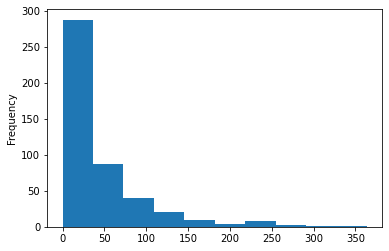

In [ ]:
baseline_results['query_time'].plot.hist()

In [ ]:
import numpy as np
# runtimes of the (failed) baseline for the 25 longest times
np.mean([ 363.7742130756378,  291.6148929595947,   281.141813993454,
 272.10498690605164,  270.1439461708069, 254.03415393829346,
 248.46835708618164, 240.88548374176025, 238.94654488563538,
 235.36567282676697, 231.51784205436707, 219.46794271469116,
   218.599524974823, 211.92099380493164, 201.89055180549622,
  197.6160020828247, 194.89223194122314, 169.23194003105164,
  166.6778576374054, 165.57918691635132, 164.33562684059143,
 159.44380903244019, 153.68555212020874, 153.02912378311157,
 147.26271319389343])

218.06523858070375

For runs it is thus recommended to set the timeout to 200

In [ ]:
# The reason it failed was because I forgot to append the relevant doc id for the retrieved query
# Not all queries were evaluated due to time out:
print(f'There were 467 total queries, and {len(baseline_results)} were evaluated\nMissing: {467-len(baseline_results)} queries')

There were 467 total queries, and 462 were evaluated
Missing: 5 queries


There were 5 out of 467 queries that took longer than the original 300 second timeout

------------


## Results:

Failed queries taking longer than 200 seconds: [54, 61, 101, 113, 162, 200, 221, 261, 282, 291]

In [ ]:
failed_query_ids= [54, 61, 101, 113, 162, 200, 221, 261, 282, 291]

In [ ]:
# Load the results for the evaluation
import bz2
import _pickle as pickle
# results with timout 200
baseline_results = pickle.load(bz2.BZ2File('baseline_results_script.pkl.bz2', 'rb'))
eval_queries = pickle.load(bz2.BZ2File('eval_queries.pkl.bz2', 'rb'))

In [ ]:
baseline_results

,id,retrieved,query_time
0,0,"[<dbpedia:Balkan_cuisine>, <dbpedia:North_Amer...",6.901839
1,1,[<dbpedia:Edinburgh_School_of_Architecture_and...,7.984369
2,2,"[<dbpedia:Saab_90>, <dbpedia:List_of_Pennsylva...",15.805974
3,3,"[<dbpedia:Index_of_World_War_II_articles_(A)>,...",92.484720
4,4,"[<dbpedia:List_of_German_Army_Groups_in_WWII>,...",25.081839
...,...,...,...
452,462,"[<dbpedia:Football_on_British_TV>, <dbpedia:Au...",55.743917
453,463,"[<dbpedia:Medimmune,_Inc._v._Genentech,_Inc.>,...",13.400180
454,464,"[<dbpedia:List_of_Mexican_writers>, <dbpedia:M...",20.569162
455,465,"[<dbpedia:Ze_plane!_Ze_plane!>, <dbpedia:Bend_...",27.519474


In [ ]:
#  average query time
from scipy import stats
import numpy as np
querytimes = baseline_results['query_time']
mean_query_time = np.mean(querytimes)
median_query_time = np.median(baseline_results['query_time'])
mode_query_time = stats.mode(round(baseline_results['query_time'], 1))
print(f'Mean query times: {round(mean_query_time, 2)} seconds\nMedian query times: {round(median_query_time, 2)} seconds\nMode query times when query times rounded to 1 decimal: {str(mode_query_time.mode)} appeared {str(mode_query_time.count)} times')


Mean query times: 36.97 seconds
Median query times: 22.33 seconds
Mode query times when query times rounded to 1 decimal: [19.5] appeared [6] times


In [ ]:
display(querytimes.nlargest(10), querytimes.nsmallest(10))

209    230.856972
82     229.630715
162    227.823075
187    227.225079
269    226.967174
273    226.838892
232    199.886051
122    198.782909
140    186.365246
379    173.299585
Name: query_time, dtype: float64

333    0.003071
377    0.088790
7      0.096607
367    0.125969
341    0.265658
335    0.326665
364    0.456489
267    0.504743
218    0.614511
378    0.937094
Name: query_time, dtype: float64

The longest query times seem to exceed the 200 second time out. It could be that the count function does not reset the time measurement and instead adds the time to the next query's time, or the timeout is not triggered in time. Since there's less query times that exceed the 200 second timeout (6) than failed queries (10), we can assume the timeout function misfired a few times during the evaluation.

Text(0.5, 0, 'Query Time')

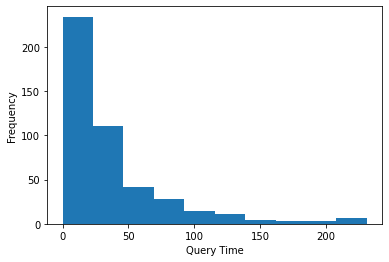

In [ ]:
# frequency of query times
baseline_results['query_time'].plot.hist();
plt.xlabel('Query Time')


In [ ]:
# all needed data for evaluation
ids = baseline_results['id']
evaluated_queries = [eval_queries['query'][id] for id in ids]
relevant_entities = [eval_queries['relevant_entities'][id] for id in ids]
very_relevant_entities = [eval_queries['very_relevant_entities'][id] for id in ids]
retrieved_entities = baseline_results['retrieved']

In [ ]:
len_eval_queries = [len(query.split()) for query in evaluated_queries]

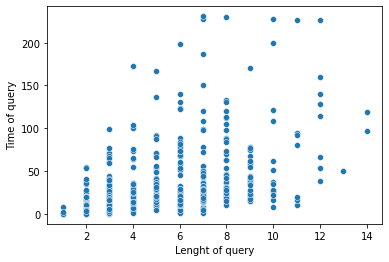

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

# plot query time with query lenghts
sns.scatterplot(y =querytimes, x = len_eval_queries);
plt.xlabel('Lenght of query');
plt.ylabel('Time of query');

### Precision Recall @n

In [ ]:
assesed_retrieved_precision_recall = []
len_relevants = []
assesed_retrieved_nDCG = []

for retrievedentities, relevantentities, veryrelevantentities in zip(retrieved_entities, relevant_entities, very_relevant_entities):
    assesed_precision_recall = []
    assesed_nDCG = []

    for entity in retrievedentities:
        if entity in relevantentities:
            assesed_precision_recall.append(1)
            assesed_nDCG.append(1)

        if entity in veryrelevantentities:
            assesed_precision_recall.append(1)
            assesed_nDCG.append(2)

        else:
            assesed_precision_recall.append(0)
            assesed_nDCG.append(0)
    
    len_relevants.append(len(relevantentities) + len(veryrelevantentities))

    assesed_retrieved_precision_recall.append(assesed_precision_recall)
    assesed_retrieved_nDCG.append(assesed_nDCG)

In [ ]:
# precision at n micro macro average
import numpy as np

def micro_macro_precision_recall_at_n(binary_assement_list:list, number_of_relevant_entities:list, n):
    total_relevant = 0
    total_number_retrieved = 0
    precision_scores = []
    recall_scores = []

    for scores, number_relevant in zip(binary_assement_list, number_of_relevant_entities):
        if len(scores) < n :
            continue
        scores = scores[:n]
        relevant = sum(scores)
        number_retrieved = len(scores)
        precision = relevant/number_retrieved
        recall = relevant/number_relevant


        precision_scores.append(precision)
        recall_scores.append(recall)
        total_relevant += relevant
        total_number_retrieved += number_retrieved

    micro_average_precision = total_relevant/total_number_retrieved
    macro_average_precision = np.mean(precision_scores)

    micro_average_recall = total_relevant/sum(number_of_relevant_entities)
    macro_average_recall = np.mean(recall_scores)

    return micro_average_precision, macro_average_precision, micro_average_recall, macro_average_recall

# PLOT PRECISION AT N RECALL AT N Take the scores over the length of the scores

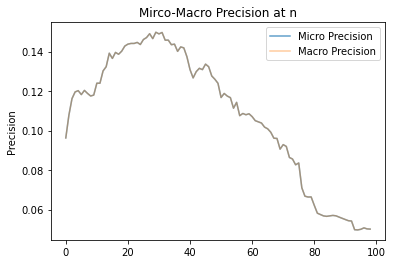

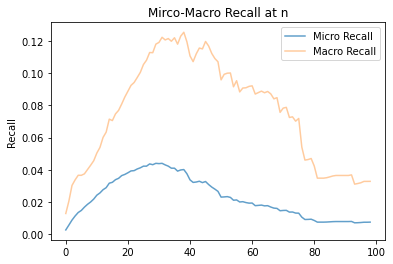

In [ ]:
import matplotlib.pyplot as plt
micro_p = []
macro_p = []
micro_r = []
macro_r = []

for n in range(1, 100):
    micro_average_precision, macro_average_precision, micro_average_recall, macro_average_recall = micro_macro_precision_recall_at_n(assesed_retrieved_precision_recall, len_relevants, n)
    micro_p.append(micro_average_precision)
    macro_p.append(macro_average_precision)
    micro_r.append(micro_average_recall)
    macro_r.append(macro_average_recall)

plt.plot(micro_p, alpha=0.7, label='Micro Precision');
plt.title('Mirco-Macro Precision at n')
plt.ylabel('Precision')
plt.plot(macro_p, alpha=0.4, label='Macro Precision');
plt.legend()
# plt.title('Marco Precision at n')
# plt.ylabel('Precision')
plt.show();
plt.plot(micro_r, alpha=0.7, label='Micro Recall');
plt.title('Mirco-Macro Recall at n')
plt.ylabel('Recall')
plt.plot(macro_r, alpha=0.4, label='Macro Recall');
plt.legend()


In [ ]:
total_relevant = 0
total_number_retrieved = 0
precision_scores = []
recall_scores = []

for id, (scores, number_relevant) in enumerate(zip(assesed_retrieved_precision_recall, len_relevants)):
    relevant = sum(scores)
    number_retrieved = len(scores)
    precision = relevant/number_retrieved
    recall = relevant/number_relevant


    precision_scores.append(precision)
    recall_scores.append(recall)
    total_relevant += relevant
    total_number_retrieved += number_retrieved

micro_average_precision = total_relevant/total_number_retrieved
macro_average_precision = np.mean(precision_scores)

micro_average_recall = total_relevant/sum(len_relevants)
macro_average_recall = np.mean(recall_scores)

print(f'The Global Precision:\nMicro Average: {micro_average_precision}\nMacro Average: {macro_average_precision}\n')
print(f'The Global Recall:\nMicro Average: {micro_average_recall}\nMacro Average: {macro_average_recall}')

The Global Precision:
Micro Average: 0.08975160575228784
Macro Average: 0.09253184067314195

The Global Recall:
Micro Average: 0.09541938602852308
Macro Average: 0.11006010585736328


### DCG, iDCG, nDCG @n

In [ ]:
import numpy as np

def dcg_idcg_ndcg(retrieved_relevance_DCG_scores:list, n:int):
    # Relevance scores in Ideal order
    sorted_relevace = sorted(retrieved_relevance_DCG_scores[:n], reverse=True)
    # Relevance scores in output order
    relevance_score = retrieved_relevance_DCG_scores[:n]

    def discountedCumulativeGain(result):
        dcg = []
        for idx, val in enumerate(result): 
            numerator = 2**val - 1
            # add 2 because python 0-index
            denominator =  np.log2(idx + 2) 
            score = numerator/denominator
            dcg.append(score)
        return sum(dcg)

    def normalizedDiscountedCumulativeGain(result, sorted_result): 
        dcg = discountedCumulativeGain(result)
        idcg = discountedCumulativeGain(sorted_result)
        ndcg = dcg / idcg
        return ndcg

    
    return discountedCumulativeGain(relevance_score), discountedCumulativeGain(sorted_relevace), normalizedDiscountedCumulativeGain(relevance_score, sorted_relevace)

In [ ]:
import numpy as np

mean_dcg_at_n, mean_idcg_at_n, mean_ndcg_at_n, mean_skipped_at_n = [], [], [], []

for n in range(1, 100):
    dcg_at_n, idcg_at_n, ndcg_at_n, skipped = [], [], [], 0
    
    for scores in assesed_retrieved_nDCG:
        if len(scores)< n:
            skipped += 1
            continue
        dcg, ideal_dcg, ndcg  = dcg_idcg_ndcg(scores, n)[0], dcg_idcg_ndcg(scores, n)[1], dcg_idcg_ndcg(scores, n)[2]
        dcg_at_n.append(dcg)
        idcg_at_n.append(ideal_dcg)
        ndcg_at_n.append(ndcg)


    mean_dcg_at_n.append(np.mean(dcg_at_n))
    mean_idcg_at_n.append(np.mean(dcg_at_n))
    mean_ndcg_at_n.append(np.mean(dcg_at_n))
    mean_skipped_at_n.append(skipped/len(assesed_retrieved_nDCG)*100)

    

/var/folders/wt/zc3p8xys6pzdscmtyvwvlrkc0000gn/T/ipykernel_22157/473647459.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ndcg = dcg / idcg


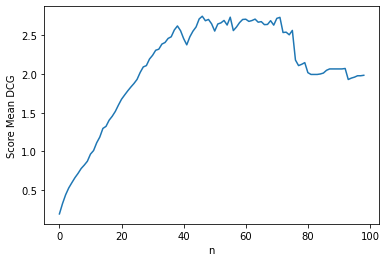

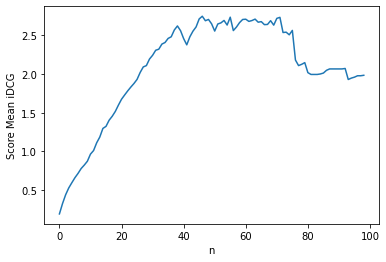

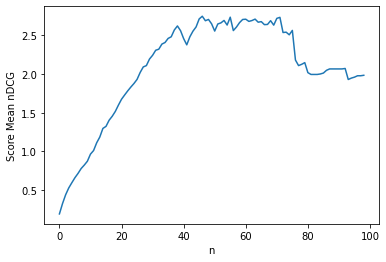

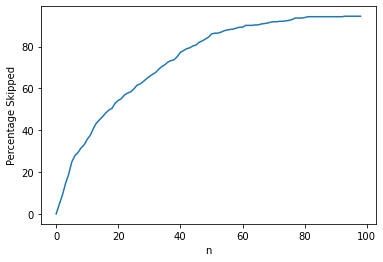

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_dcg_at_n)
plt.ylabel('Score Mean DCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_idcg_at_n)
plt.ylabel('Score Mean iDCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_ndcg_at_n)
plt.ylabel('Score Mean nDCG')
plt.xlabel('n')
plt.show()
plt.plot(mean_skipped_at_n)
plt.ylabel('Percentage Skipped')
plt.xlabel('n')
plt.show()


/var/folders/wt/zc3p8xys6pzdscmtyvwvlrkc0000gn/T/ipykernel_22157/473647459.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ndcg = dcg / idcg


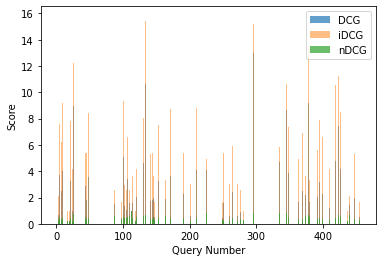

In [ ]:
n = 40
dcg_at_n, idcg_at_n, ndcg_at_n = [], [], []
show_dense = False

for i in assesed_retrieved_nDCG:
    scores = i[:n]
    if (len(scores)< n) and show_dense: continue
    if len(scores)< n:
        dcg_at_n.append(0)
        idcg_at_n.append(0)
        ndcg_at_n.append(0)
        continue
    dcg, ideal_dcg, ndcg  = dcg_idcg_ndcg(scores, n)[0], dcg_idcg_ndcg(scores, n)[1], dcg_idcg_ndcg(scores, n)[2]
    dcg_at_n.append(dcg)
    idcg_at_n.append(ideal_dcg)
    ndcg_at_n.append(ndcg)

plt.bar(range(len(dcg_at_n)), dcg_at_n, label='DCG', alpha=0.7)
plt.bar(range(len(idcg_at_n)),idcg_at_n, label="iDCG", alpha=0.5)
plt.bar(range(len(ndcg_at_n)),ndcg_at_n, label='nDCG', alpha=0.7)
plt.ylabel('Score')
plt.xlabel('Query Number')
plt.legend()
plt.show()